# 03 - Full-Waveform Inversion (FWI)

This notebook is the third in a series of tutorial highlighting various aspects of seismic inversion based on Devito operators. In this second example we aim to highlight the core ideas behind seismic inversion, where we create an image of the subsurface from field recorded data. This tutorial follows on the modelling tutorial and will reuse the modelling and velocity model.

## Inversion requirement

Seismic inversion relies on two known parameters:

- **Field data** - or also called **recorded data**. This is a shot record corresponding to the true velocity model. In practice this data is auired as described in the first tutorial. In order to siplify this tutorial we will fake field data by modelling it with the true velocity model.

- **Initial velocity model**. This is a velocity model that has been obtained by processing the field data. This model is a rough and very smooth estimate of the velocity as an initial estimate for the inversion. This is a necessary requirement for any optimization (method).

## Inversion computational setup

In this tutorial, we will introduce the gradient operator. This operator corresponds to the imaging condition introduced in the previous tutorial with some minor modifications that are defined by the objective function and its derivative. We will define this two terms in the tutorial too.

## Notes on the operators

As we already describe the creation of a forward modelling operator, we will only call an wraped function here. This wrapers already contains all the necessary operator for seismic modeling, imaging and inversion, however any new operator will be fully described and only used from the wrapper in the next tutorials.

In [1]:
import numpy as np
%matplotlib inline

from devito import configuration
configuration['log_level'] = 'WARNING'

## Computational considerations

As we will see in this tutorial, FWI is again very computationally demanding, even more so than RTM. To keep this tutorial as light-wight as possible we therefore again use a very small demonstration model. We also define here a few parameters for the final example runs that can be changed to modify the overall runtime of the tutorial.

In [2]:
nsources = 21  # Number of sources to create gradient from
nreceivers = 101  # Number of receiver locations per shot 
    
if configuration['travis_test']:
    # A reduced setup for automated testing
    fwi_iterations = 1  # Number of outer FWI iterations
else:
    # Default setup for demonstration purposes
    fwi_iterations = 8  # Number of outer FWI iterations

# True and smooth velocity models.

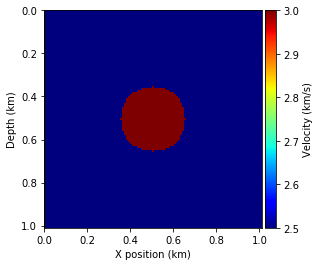

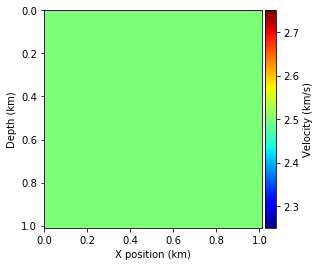

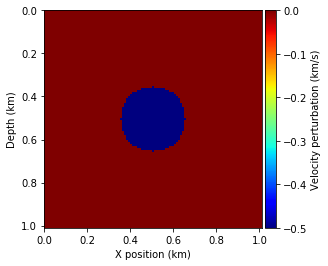

In [3]:
# Define true and initial model
from examples.seismic import demo_model, plot_velocity, plot_perturbation

shape = (101, 101)  # Number of grid point (nx, nz)
spacing = (10., 10.)  # Grid spacing in m. The domain size is now 1km by 1km
origin = (0., 0.)  # Need origin to define relative source and receiver locations

model = demo_model('circle', vp=3.0, vp_background=2.5,
                    origin=origin, shape=shape, spacing=spacing, nbpml=40)

model0 = demo_model('circle', vp=2.5, vp_background=2.5,
                     origin=origin, shape=shape, spacing=spacing, nbpml=40)

plot_velocity(model)
plot_velocity(model0)
plot_perturbation(model0, model)

##### True and smooth data

We can now generate the shot record correspondingto both models. The difference between this two record will be the basis of the inversion procedure. The acquisition geometry is the same as in the previous tutorial.

In this tutorial, we will use the easiest case for inverrsion, namely a transmission experiment. The sources are located on one side of the model and the receivers on the other side. This allow to record most of the information necessary for inversion, as reflection only usually lead to poor inversion results.

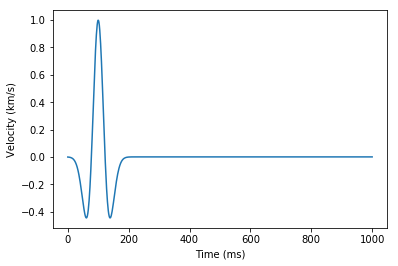

In [4]:
# Define acquisition geometry: source
from examples.seismic import RickerSource, Receiver

# Define time discretization according to grid spacing
t0 = 0.
tn = 1000.  # Simulation last 1 second (1000 ms)
dt = model.critical_dt  # Time step from model grid spacing
nt = int(1 + (tn-t0) / dt)  # Discrete time axis length
time = np.linspace(t0, tn, nt)  # Discrete modelling time

f0 = 0.010  # Source peak frequency is 10Hz (0.010 kHz)
src = RickerSource(name='src', ndim=2, f0=f0, time=np.linspace(t0, tn, nt))
src.coordinates.data[0, :] = np.array(model.domain_size) * .5
src.coordinates.data[0, 0] = 20.  # 20m from the left end

# We can plot the time signature to see the wavelet
src.show()

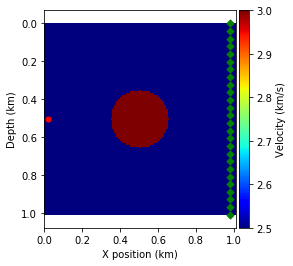

In [5]:
# Define acquisition geometry: receivers

# Initialize receivers for synthetic data
true_d = Receiver(name='rec', npoint=nreceivers, ntime=nt, ndim=2)
true_d.coordinates.data[:, 1] = np.linspace(0, model.domain_size[0], num=nreceivers)
true_d.coordinates.data[:, 0] = 980. # 20m from the right end

# Initialize receivers for inversion data
smooth_d = Receiver(name='rec', npoint=nreceivers, ntime=nt, ndim=2)
smooth_d.coordinates.data[:, 1] = np.linspace(0, model.domain_size[0], num=nreceivers)
smooth_d.coordinates.data[:, 0] = 980. # 20m from the right end

# Plot acquisition geometry
plot_velocity(model, source=src.coordinates.data,
              receiver=true_d.coordinates.data[::4, :])

In [6]:
# Compute synthetic data with forward operator 
from examples.seismic.acoustic import AcousticWaveSolver

solver = AcousticWaveSolver(model, src, true_d, space_order=4)
true_d, _, _ = solver.forward(src=src, rec=true_d, m=model.m)

In [7]:
# Compute initial data with forward operator 
smooth_d, _, _ = solver.forward(src=src, rec=smooth_d, m=model0.m)

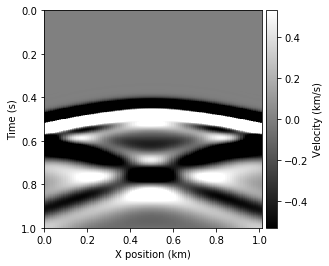

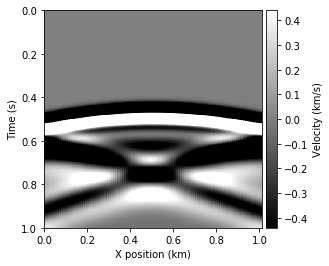

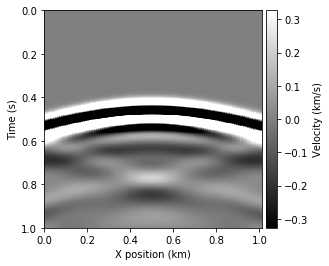

In [8]:
# Plot shot record for true and smooth velocity model and the difference
from examples.seismic import plot_shotrecord

plot_shotrecord(true_d.data, model, t0, tn)
plot_shotrecord(smooth_d.data, model, t0, tn)
plot_shotrecord(smooth_d.data - true_d.data, model, t0, tn)

The only difference between the smooth and the true velocity model is the value of the velocity. The dimensions of the model are unchanged. We can therefore reuse the forward modelling operator we just build and only specify the new velocity model, the shot record we want the result to be in and a new initialized wavefield.

If the shot record is not specified, the data will still be computed but will overwrite the true shot record. Concerning the initialization of a new wavefield, this comes from the simplified interface of this tutorial. In practice, a warapper would be built around the operator to reinitialize any field at runtime.

# Full-Waveform Inversion


## Formulation

Full-waveform inversion (FWI) aims to invert an accurate model of the
discrete wave velocity, $\mathbf{c}$, or equivalently the square
slowness of the wave, $\mathbf{m} = \frac{1}{\mathbf{c}^2}$, from a given
set of measurements of the pressure wavefield
$\mathbf{u}$. [refs] shows that this can be expressed as the following optimization problem:

\begin{aligned}
	\mathop{\hbox{minimize}}_{\mathbf{m}} \Phi_s(\mathbf{m})&=\frac{1}{2}\left\lVert\mathbf{P}_r
	\mathbf{u} - \mathbf{d}\right\rVert_2^2 \\
	\mathbf{u} &= \mathbf{A}(\mathbf{m})^{-1} \mathbf{P}_s^T \mathbf{q}_s, 
\end{aligned}

where $\mathbf{P}_r$ is the sampling operator at the receiver
locations, $\mathbf{P}_s^T$ is the injection operator at the source
locations, $\mathbf{A}(\mathbf{m})$ is the operator
representing the discretized wave equation matrix, $\mathbf{u}$ is the
discrete synthetic pressure wavefield, $\mathbf{q}_s$ is the
corresponding pressure source and $\mathbf{d}$ is the measured data. It
is worth noting that $\mathbf{m}$ is the
unknown in this formulation and that multiple implementations of the
wave equation operator $\mathbf{A}(\mathbf{m})$ are possible. We already defined
a concrete solver scheme for $\mathbf{A}(\mathbf{m})$ in the forst tutorial , including appropriate
implementations of the sampling operator $\mathbf{P}_r$ and source term
$\mathbf{q}_s$.

To solve this optimization problem using a gradient-based method, we use the
adjoint-state method to evaluate the gradient $\nabla\Phi_s(\mathbf{m})$:

\begin{align}
 \nabla\Phi_s(\mathbf{m})=\sum_{\mathbf{t} =1}^{n_t}\mathbf{u}[\mathbf{t}] \mathbf{v}_{tt}[\mathbf{t}] =\mathbf{J}^T\delta\mathbf{d}_s,
\end{align}

where $n_t$ is the number of computational time steps, $\delta\mathbf{d}_s = \left(\mathbf{P}_r \mathbf{u} - \mathbf{d} \right)$ is the data residual (difference between the measured data and the modelled data), $\mathbf{J}$ is the Jacobian operator and $\mathbf{v}_{tt}$ is the second-order time derivative of the adjoint wavefield solving:

\begin{align}
 \mathbf{A}^T(\mathbf{m}) \mathbf{v} = \mathbf{P}_r^T \delta\mathbf{d}.
\end{align}

We see that the gradient of the FWI function is the previously defined imaging condition with an extra second-order time derivative. We will therefore reuse the operators defined previously inside a Devito wrapper.


## Computational considerations

As we just explaine, the forward wave-equation is solved forward in time while the adjoint wave-equation is solved in a reversed time order. Therefor, the correlation of this two field over time requires to store one of the two fields. The computational workflow for imaging follows:

- Simulate the forward wave-equation with the background veocity model to get the synthetic data and save the full wavefield $\mathbf{u}$
- Compute the data residual
- Back-propagate the data residual and compute on the fly the Image contribution at each time step. 

This workflow is applied to multiple source position and sumed to obatain the full image of the subsurface.

In [9]:
# Create FWI gradient kernel 
from devito import DenseData, clear_cache
solver = AcousticWaveSolver(model, src, true_d, space_order=4)

# Prepare the shifting source locations
sources = np.linspace(0, 1000, num=nsources)

def fwi_gradient(m_in):
    # Important: We force previous wavefields to be destroyed,
    # so that we may reuse the memory.
    clear_cache()
    
    # Create symbols to hold the gradient and residual
    grad = DenseData(name="grad", shape=model.shape_domain, dtype=model.dtype)
    residual = Receiver(name='rec', data=smooth_d.data - true_d.data,
                        coordinates=true_d.coordinates.data)
    objective = 0.
    
    for location in sources:
        # Update source location
        src.coordinates.data[0, 0] = 30.
        src.coordinates.data[0, 1] = location
        
        # Generate synthetic data from true model
        solver.forward(src=src, rec=true_d, m=model.m)
        
        # Compute smooth data and full forward wavefield u0
        _, u0, _ = solver.forward(src=src, rec=smooth_d, m=m_in, save=True)
        
        # Compute gradient from data residual and update objective function 
        residual.data[:] = smooth_d.data[:] - true_d.data[:]
        objective += .5*np.linalg.norm(residual.data.reshape(-1))**2
        solver.gradient(rec=residual, u=u0, m=m_in, grad=grad)
    
    grad.data[0:25,:] = 0.
    grad.data[-25:,:] = 0.
    return objective, grad.data

In [10]:
# Compute gradient of initial model
ff, update = fwi_gradient(model0.m)
print('Objective value is %f ' % ff)

Objective value is 134551.641609 


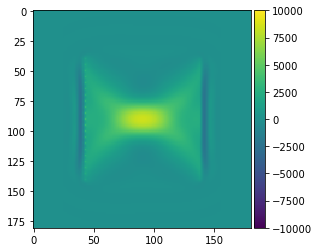

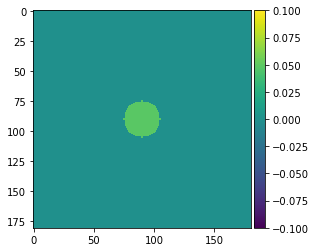

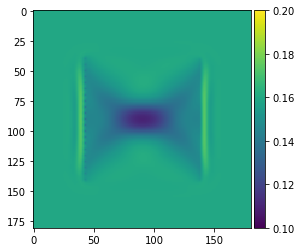

In [11]:
# Plot FWI gradient and model update
from examples.seismic import plot_image

# Plot the FWI gradient
plot_image(update, vmin=-1e4, vmax=1e4)

# Plot the difference between the true and initial model.
# This is not know in practice as only the initial model is provided.
plot_image(model0.m.data - model.m.data, vmin=-1e-1, vmax=1e-1)

# Show what the update does to the model
alpha = .05 / np.max(update)
plot_image(model0.m.data - alpha*update, vmin=.1, vmax=.2)

We see that the gradient and the true perturbation have the same sign, therefore, with an appropriate scaling factor, we will update the model in the correct direction.

In [12]:
# Create bounds constraint
def bound_constr(m):
    m[m<.1] = .08 # Maximum accepted velocity is 3.5 km/sec (true is 3 km/sec)
    m[m>.2] = .25 # Minimum accepted velocity is 2 km/sec (true is 2.5 km/sec)
    return m

In [13]:
# Run FWI with gradient descent
history = np.zeros((fwi_iterations, 1))
for i in range(0, fwi_iterations):
    # Compute the functional value and gradient for the current
    # model estimate
    phi, direction = fwi_gradient(model0.m)
    
    # Store the history of the functional values
    history[i] = phi
    
    # Artificial Step length for gradient descent
    # In practice this would be replaced by a Linesearch (Wolfe, ...)
    # that would guaranty functional decrease Phi(m-alpha g) <= epsilon Phi(m)
    # where epsilon is a minimum decrease constant
    alpha = .005 / np.max(direction)
    
    # Update the model estimate and inforce minimum/maximum values
    model0.m.data[:] = bound_constr(model0.m.data - alpha * direction)
    
    # Log the progress made
    print('Objective value is %f at iteration %d' % (phi, i+1))

Objective value is 134551.641609 at iteration 1
Objective value is 93070.400074 at iteration 2
Objective value is 61117.549554 at iteration 3
Objective value is 37573.859029 at iteration 4
Objective value is 21309.774518 at iteration 5
Objective value is 10858.303350 at iteration 6
Objective value is 4513.648785 at iteration 7
Objective value is 1891.318047 at iteration 8


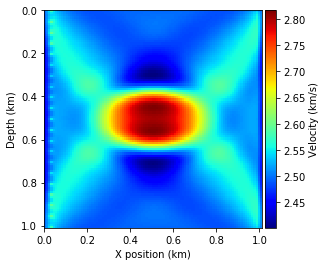

In [14]:
# Plot inverted velocity model

# First, update velocity from computed square slowness
nbpml = model.nbpml
model0.vp = np.sqrt(1. / model0.m.data[nbpml:-nbpml, nbpml:-nbpml])

plot_velocity(model0)

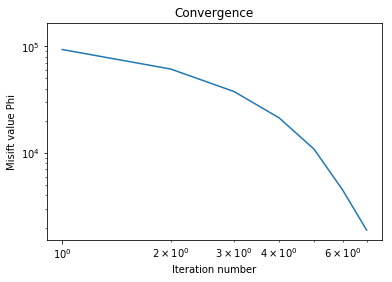

In [15]:
# Plot objective function decrease
import matplotlib.pyplot as plt

plt.figure()
plt.loglog(history)
plt.xlabel('Iteration number')
plt.ylabel('Misift value Phi')
plt.title('Convergence')
plt.show()